## Graph clustering for digits dataset

In [15]:
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.neighbors import NearestNeighbors

from sklearn.datasets import fetch_openml

import umap
import umap.plot as uplot

import igraph as ig

from sklearn.metrics import silhouette_score

from ch_11_funcs import (
        conductance, 
        average_internal_node_degree, 
        print_clustering_stats
)

plt.rcParams["figure.figsize"] = (10,10)
sns.set_theme()
random.seed(2)

### Load the dataset

In [16]:
# Load digits data
mnist = fetch_openml('mnist_784', parser='auto')

# Normalize digits data
digits_data = mnist.data/255
digit_labels = mnist.target

# Subset the dataset
digit_labels_df = pd.DataFrame(digit_labels)

label_subset_df = digit_labels_df.groupby('class').head(2000)

digits_data = digits_data.loc[label_subset_df.index, :].reset_index(drop=True)
digit_labels = label_subset_df['class'].to_numpy()

### Create the graph by inverting distances

In [17]:
N_NEIGHBORS = 20

In [18]:
# Create KNN graph
distance_matrix = kneighbors_graph(digits_data, n_neighbors=N_NEIGHBORS, mode='distance', metric='euclidean')

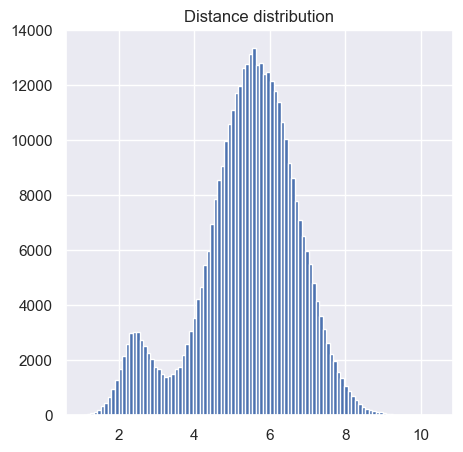

In [19]:
plt.figure(figsize=(5,5))
_ = plt.hist(distance_matrix.data, bins=100)
plt.title('Distance distribution')
plt.show()

In [20]:
sum(distance_matrix.data == 0)

0

In [21]:
# Transform distance matrix into adjacency matrix
distance_matrix.data = 1.0 / distance_matrix.data
adj_matrix = distance_matrix
#del distance_matrix

# Create graph from adjacency matrix
g = ig.Graph.Weighted_Adjacency(adj_matrix, mode="undirected")

<Axes: >

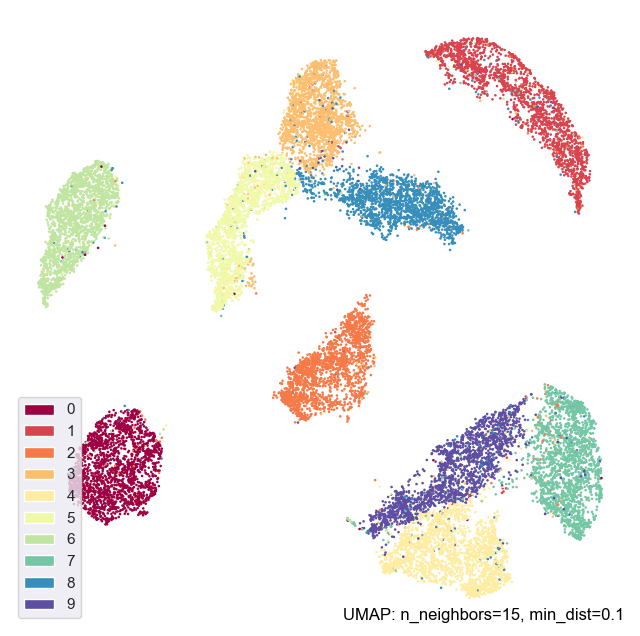

In [22]:
# Default values
umap_obj = umap.UMAP()
embedding = umap_obj.fit_transform(digits_data)

uplot.points(umap_obj, labels=digit_labels)

### Clustering

In [23]:
ig_clusters = g.community_multilevel(resolution=1, weights='weight')

print_clustering_stats(
    ig_clusters=ig_clusters,
    min_cluster_size=5
)

print('ARI: {}'.format(adjusted_rand_score(ig_clusters.membership, digit_labels)))

Cluster 0 size : 1407
Cluster 1 size : 2059
Cluster 2 size : 2279
Cluster 3 size : 614
Cluster 4 size : 1839
Cluster 5 size : 729
Cluster 6 size : 1944
Cluster 7 size : 756
Cluster 8 size : 719
Cluster 9 size : 2040
Cluster 10 size : 2039
Cluster 11 size : 1698
Cluster 12 size : 1035
Cluster 13 size : 842
Num regular clusters 14
Num noise clusters 0
Num noise cluster nodes 0
ARI: 0.7257677723302024


<Axes: >

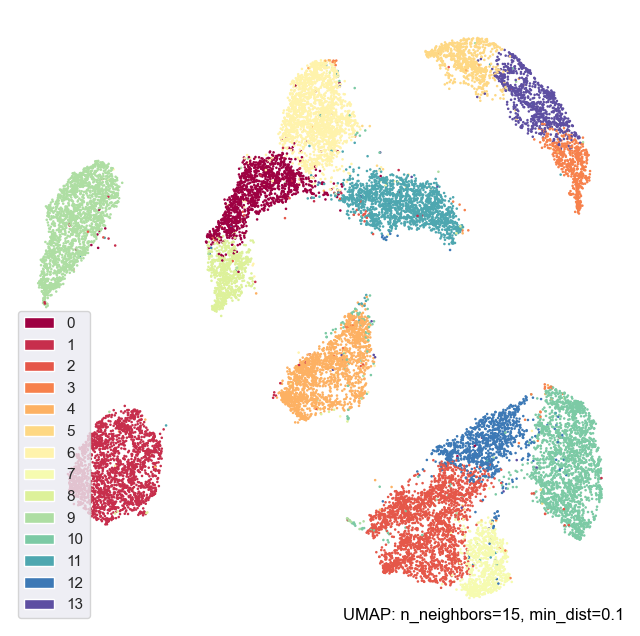

In [24]:
uplot.points(umap_obj, labels=np.array(ig_clusters.membership))

Resolution : 0.1
Resolution : 0.2
Resolution : 0.30000000000000004
Resolution : 0.4
Resolution : 0.5
Resolution : 0.6
Resolution : 0.7000000000000001
Resolution : 0.8
Resolution : 0.9
Resolution : 1.0
Resolution : 1.1


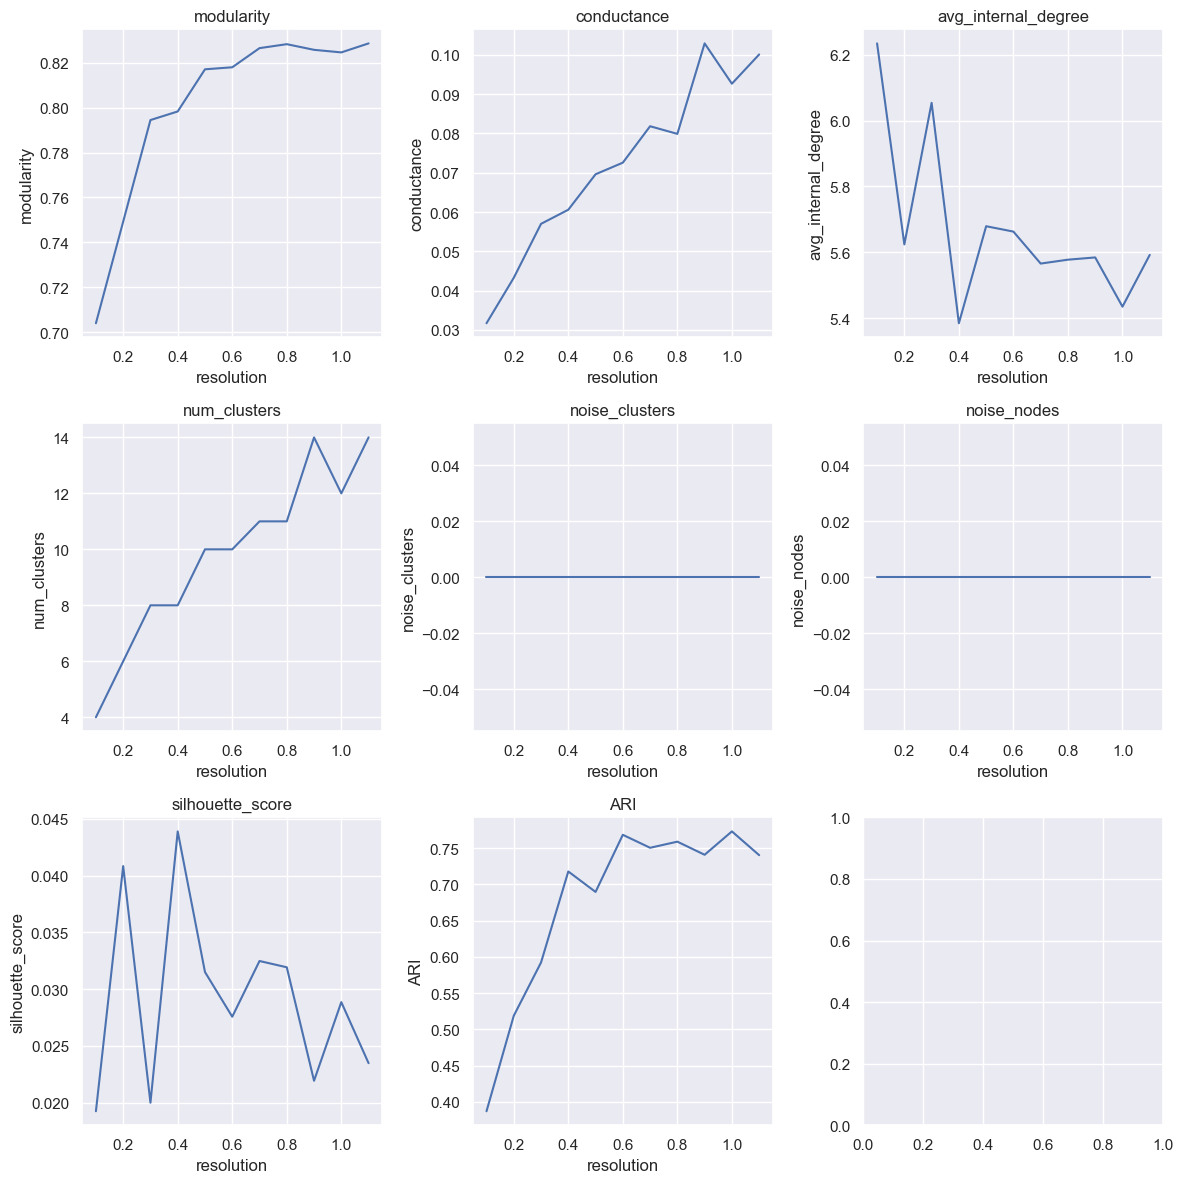

In [25]:
# Set up resolution list and minimum cluster size
resolution_list = np.arange(0.1, 1.2, 0.1)
min_cluster_size=5
stats_list = []

# Cluster and record results and each resolution
for resolution in resolution_list:
    
    print('Resolution : {}'.format(resolution))
    
    ig_clusters = g.community_multilevel(
        resolution=resolution,
        weights='weight'
    )
    
    # Deterct noise clusters by size
    noise_cluster = []
    regular_clusters = []
    
    for cluster_nodes in ig_clusters:
        
        if len(cluster_nodes) > min_cluster_size:
            regular_clusters.append(cluster_nodes)
        else:
            noise_cluster += cluster_nodes
        
    # Store results inside dict
    stats_list.append(
        {   
            'resolution':resolution,
            'modularity': g.modularity(membership=ig_clusters.membership, weights='weight'),
            'conductance': conductance(ig_clusters),
            'avg_internal_degree': average_internal_node_degree(ig_clusters),
            'num_clusters': len(regular_clusters),
            'noise_clusters': len(ig_clusters) - len(regular_clusters),
            'noise_nodes': len(noise_cluster),
            'silhouette_score': silhouette_score(digits_data, labels=ig_clusters.membership),
            'ARI': adjusted_rand_score(ig_clusters.membership, digit_labels)
        }
    )

# Transform list of dicts to dataframe
stats_df = pd.DataFrame.from_dict(stats_list)

# Plot the results

# Split columns into resoluton and other columns
res_col = 'resolution'
stat_cols = stats_df.columns.tolist()
stat_cols.remove(res_col)

# Create plot gird
ncols = 3
n = len(stat_cols)
nrows = int(np.ceil(n / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 4*nrows))  # Adjust the size as needed

# Perform plotting
if axs.ndim > 1:
    axs = axs.flatten()

for i, col in enumerate(stat_cols):
    axs[i].plot(stats_df[res_col], stats_df[col])
    axs[i].set_title(col)
    axs[i].set_xlabel(res_col)
    axs[i].set_ylabel(col)

plt.tight_layout()
plt.show()

<Axes: >

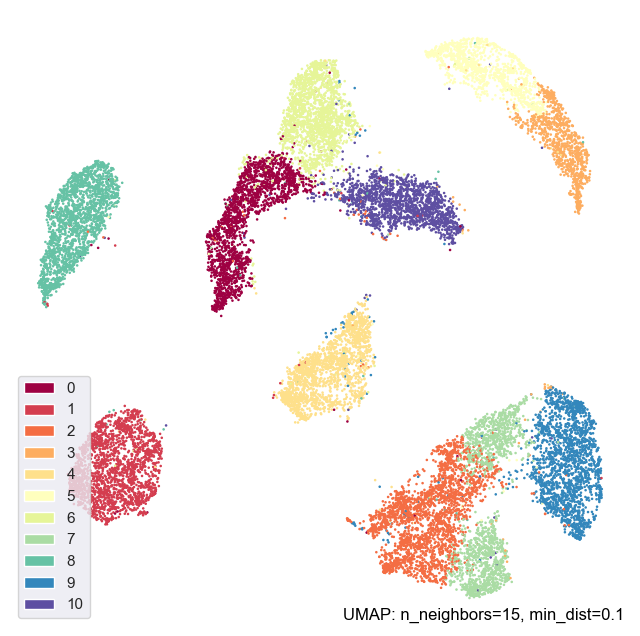

In [26]:
ig_clusters = g.community_multilevel(resolution=0.8, weights='weight')

uplot.points(umap_obj, labels=np.array(ig_clusters.membership))

<Axes: >

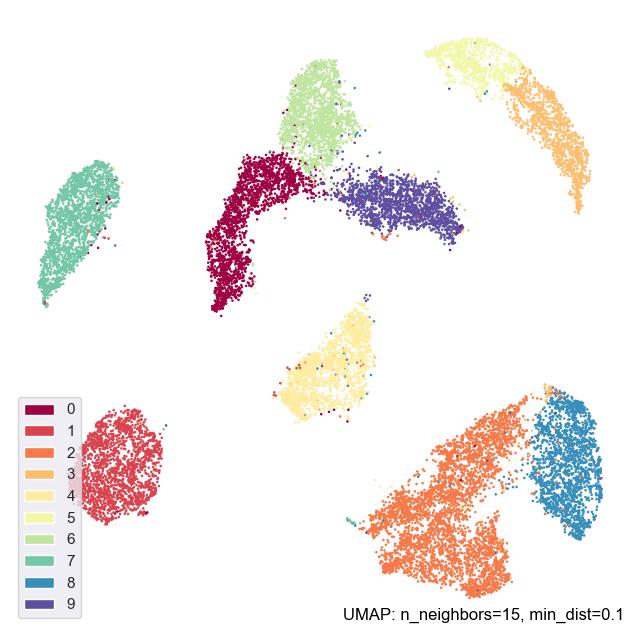

In [27]:
ig_clusters = g.community_multilevel(resolution=0.6, weights='weight')

uplot.points(umap_obj, labels=np.array(ig_clusters.membership))

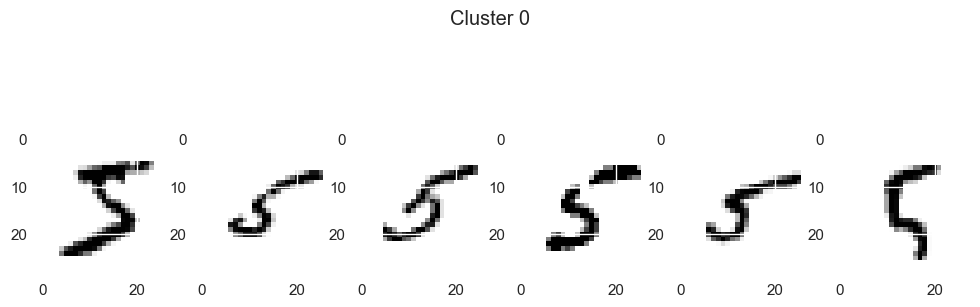

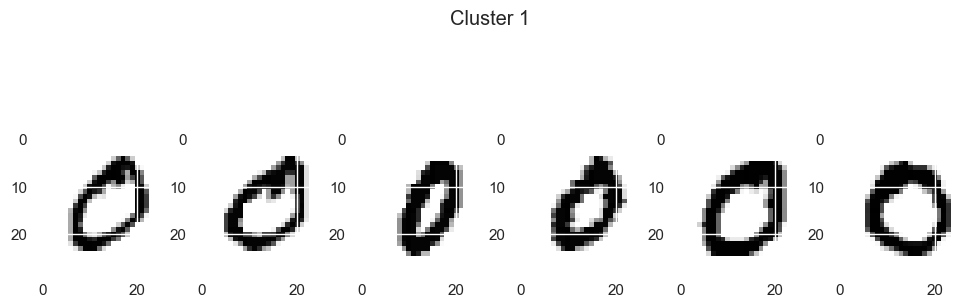

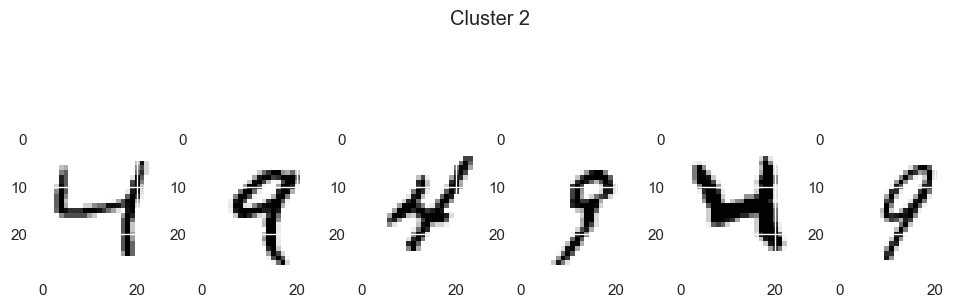

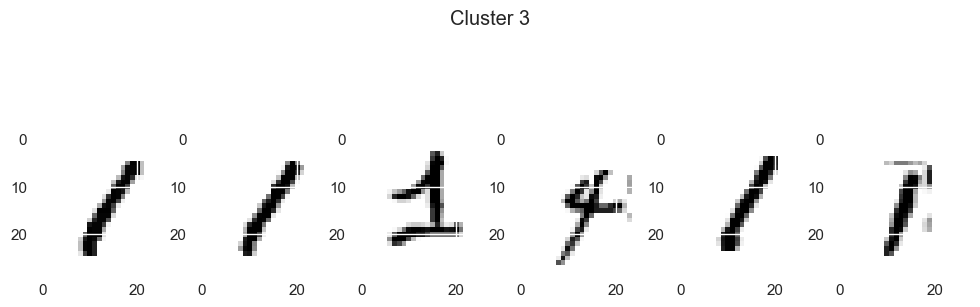

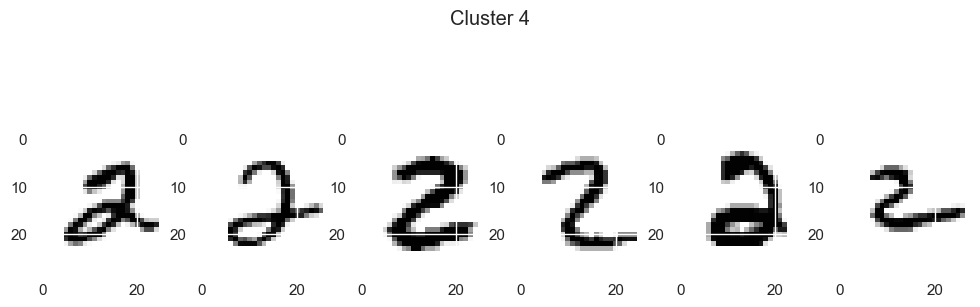

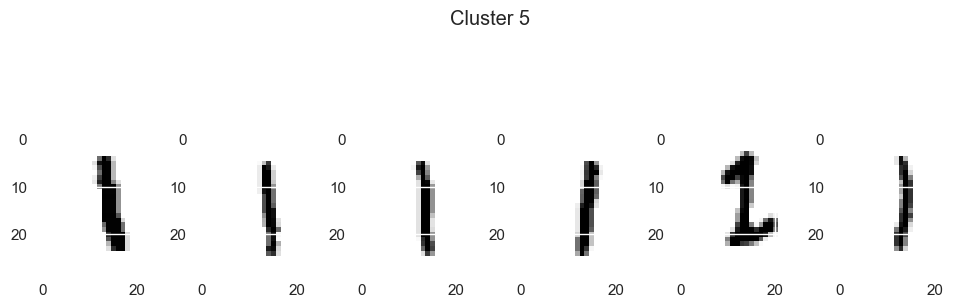

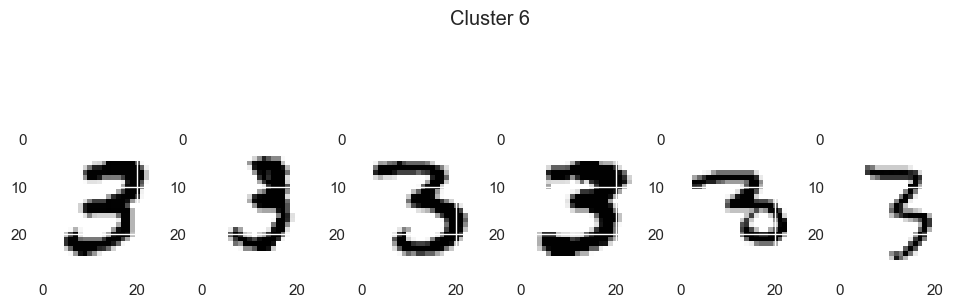

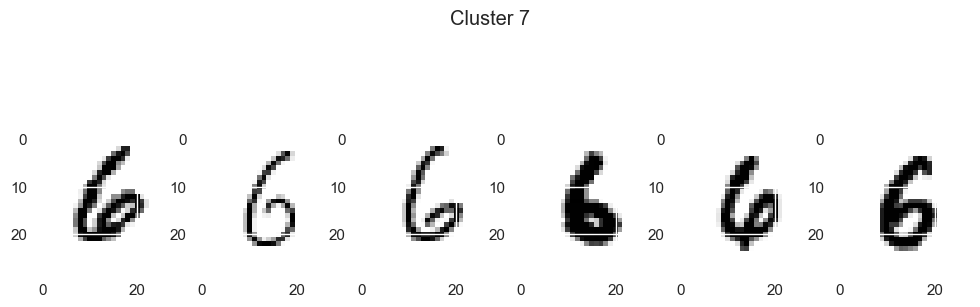

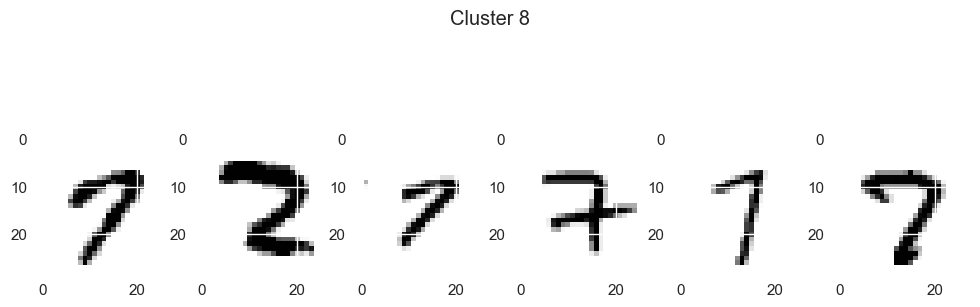

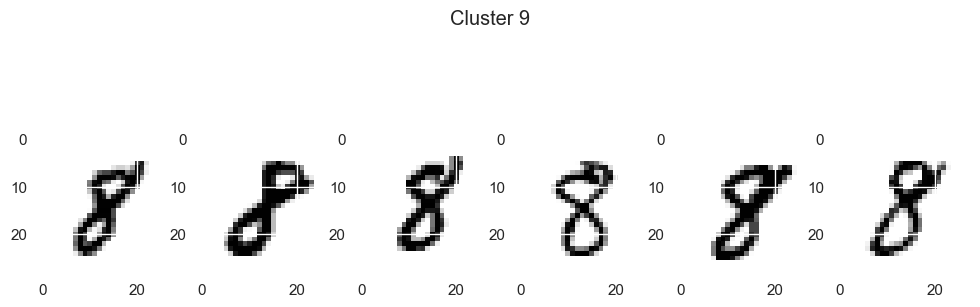

In [28]:
digits_data_rshp = np.reshape(digits_data, newshape=[digits_data.shape[0], 28, 28])

for clust_i, clust in enumerate(ig_clusters):
    
    nrows = 1
    ncols = 6
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 4*nrows))  # Adjust the size as needed

    axs = axs.flatten()

    for i, img_idx in enumerate(clust[:6]):
        axs[i].imshow(digits_data_rshp[img_idx], cmap=plt.cm.gray_r)
    fig.suptitle('Cluster {}'.format(clust_i))

In [29]:
def plot_clust_stats(start_res, end_res, step, graph, data_df, original_labels):
    
    # Set up resolution list and minimum cluster size
    resolution_list = np.arange(start_res, end_res, step)
    min_cluster_size=5
    stats_list = []

    # Cluster and record results and each resolution
    for resolution in resolution_list:
        
        print('Resolution {}'.format(resolution))
        ig_clusters = graph.community_multilevel(
            resolution=resolution,
            weights='weight'
        )
        
        # Deterct noise clusters by size
        noise_cluster = []
        regular_clusters = []
        
        for cluster_nodes in ig_clusters:
            
            if len(cluster_nodes) > min_cluster_size:
                regular_clusters.append(cluster_nodes)
            else:
                noise_cluster += cluster_nodes
            
        # Store results inside dict
        stats_list.append(
            {   
                'resolution':resolution,
                'modularity': graph.modularity(membership=ig_clusters.membership, weights='weight'),
                'conductance': conductance(ig_clusters),
                'avg_internal_degree': average_internal_node_degree(ig_clusters),
                'num_clusters': len(regular_clusters),
                'noise_clusters': len(ig_clusters) - len(regular_clusters),
                'noise_nodes': len(noise_cluster),
                'silhouette_score': silhouette_score(data_df, labels=ig_clusters.membership),
                'ARI': adjusted_rand_score(ig_clusters.membership, original_labels)
            }
        )

    # Transform list of dicts to dataframe
    stats_df = pd.DataFrame.from_dict(stats_list)

    # Plot the results

    # Split columns into resoluton and other columns
    res_col = 'resolution'
    stat_cols = stats_df.columns.tolist()
    stat_cols.remove(res_col)

    # Create plot gird
    ncols = 3
    n = len(stat_cols)
    nrows = int(np.ceil(n / ncols))

    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 4*nrows))  # Adjust the size as needed

    # Perform plotting
    if axs.ndim > 1:
        axs = axs.flatten()

    for i, col in enumerate(stat_cols):
        axs[i].plot(stats_df[res_col], stats_df[col])
        axs[i].set_title(col)
        axs[i].set_xlabel(res_col)
        axs[i].set_ylabel(col)

    plt.tight_layout()
    plt.show()

### RBF similarity

In [30]:
distance_matrix = kneighbors_graph(digits_data, n_neighbors=N_NEIGHBORS, mode='distance', metric='euclidean')

In [31]:
sigma = np.median(distance_matrix.data)

In [32]:
# Transform distance matrix into adjacency matrix
distance_matrix.data = np.exp(-(distance_matrix.data)**2 / (2 * sigma**2))

In [33]:
adj_matrix = distance_matrix

# Create graph from adjacency matrix
g = ig.Graph.Weighted_Adjacency(adj_matrix, mode="undirected")

Resolution 0.1
Resolution 0.2
Resolution 0.30000000000000004
Resolution 0.4
Resolution 0.5
Resolution 0.6
Resolution 0.7000000000000001
Resolution 0.8
Resolution 0.9
Resolution 1.0
Resolution 1.1


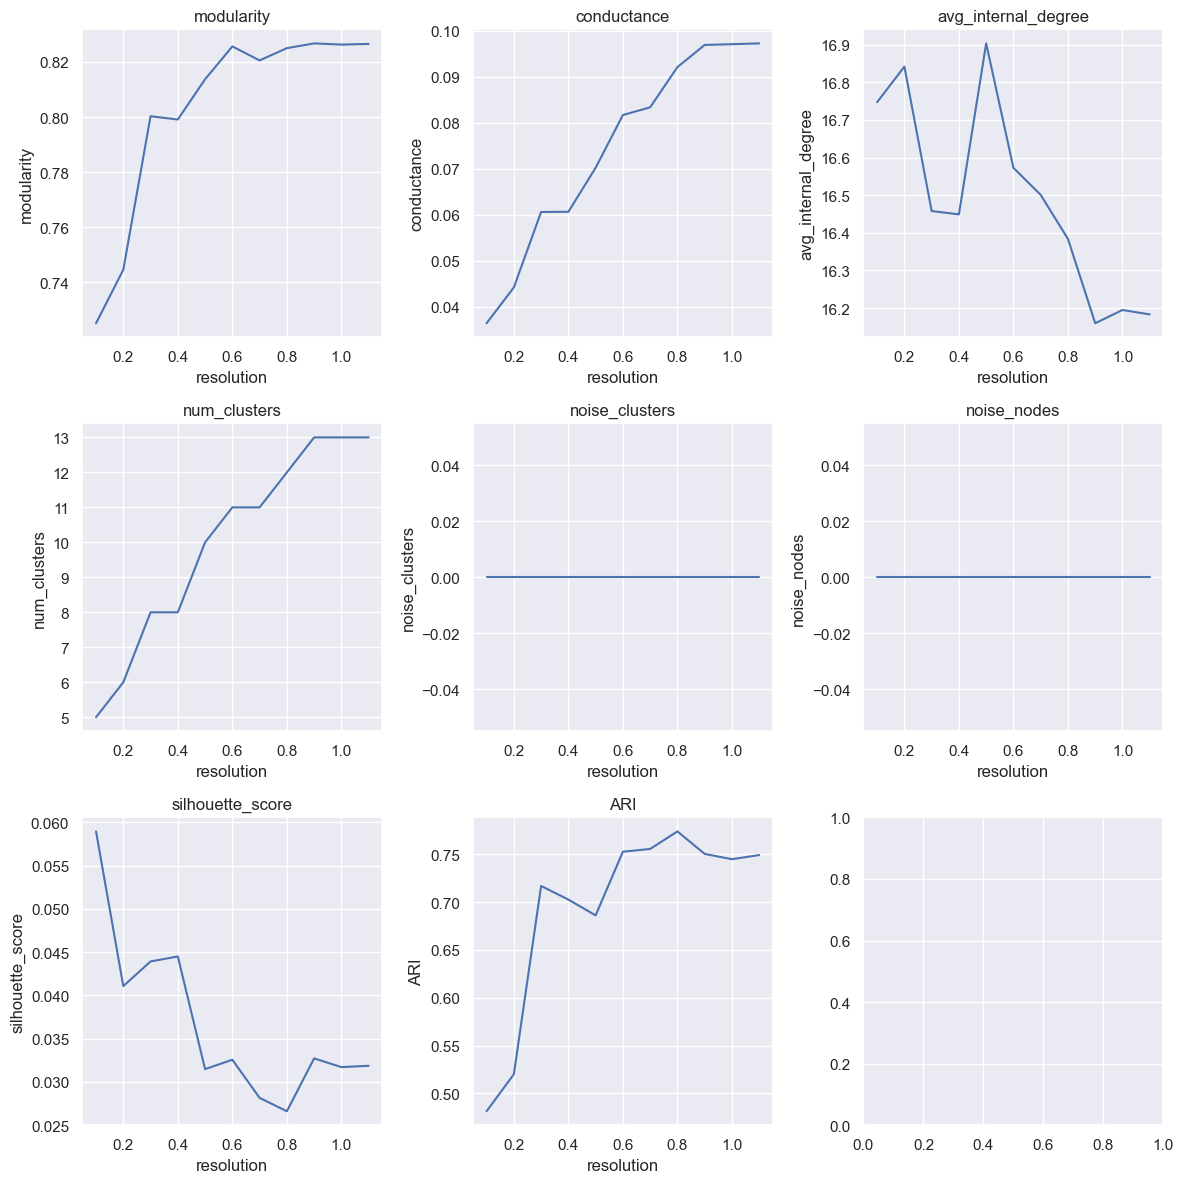

In [34]:
plot_clust_stats(
    start_res=0.1,
    end_res=1.2,
    step=0.1,
    graph=g,
    data_df=digits_data,
    original_labels=digit_labels
)

<Axes: >

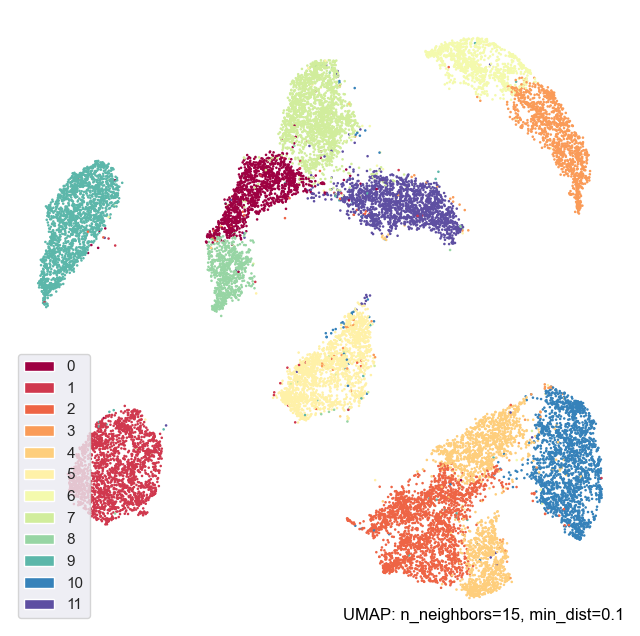

In [35]:
ig_clusters = g.community_multilevel(
    resolution=0.8,
    weights='weight'
)

uplot.points(umap_obj, labels=np.array(ig_clusters.membership))

<Axes: >

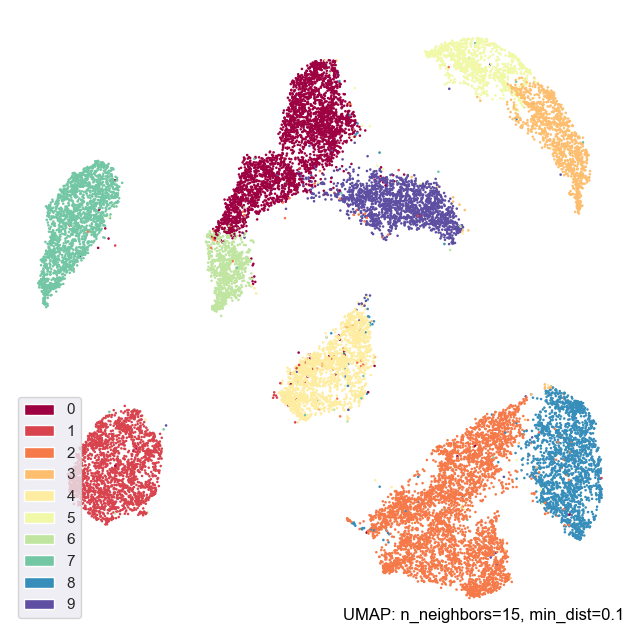

In [36]:
ig_clusters = g.community_multilevel(
    resolution=0.5,
    weights='weight'
)

uplot.points(umap_obj, labels=np.array(ig_clusters.membership))

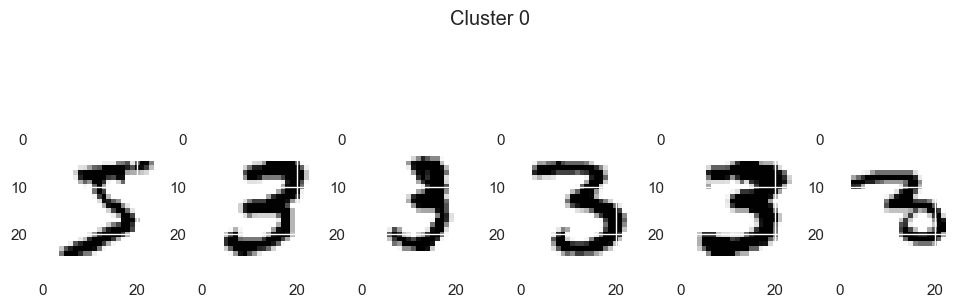

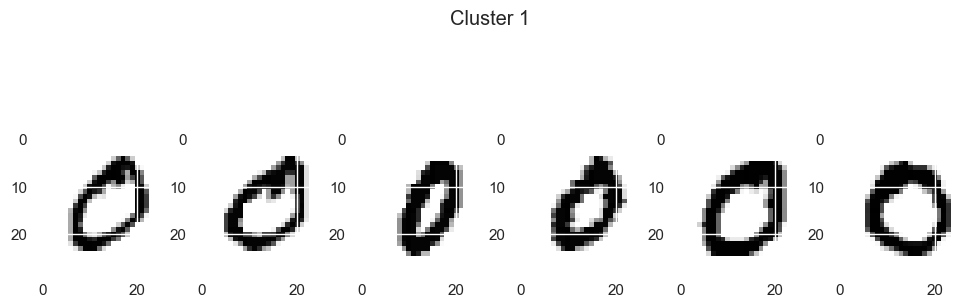

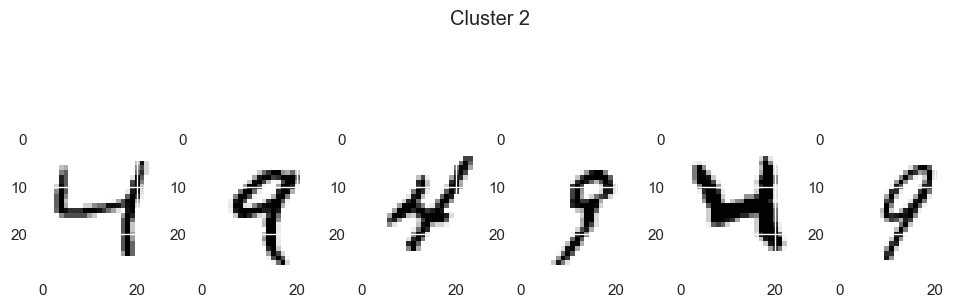

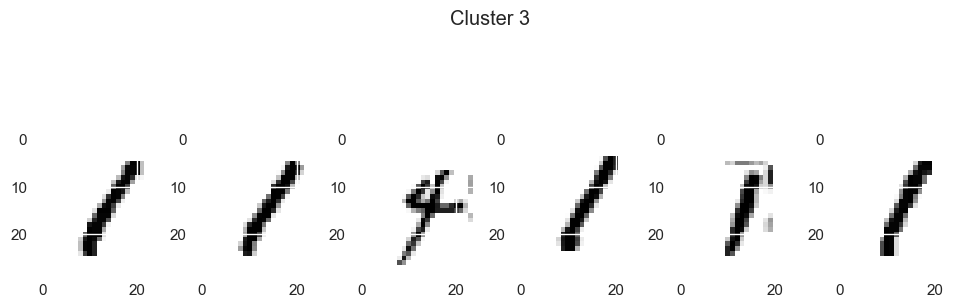

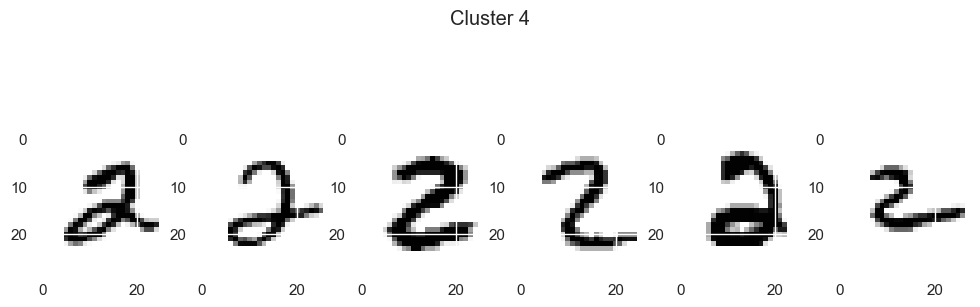

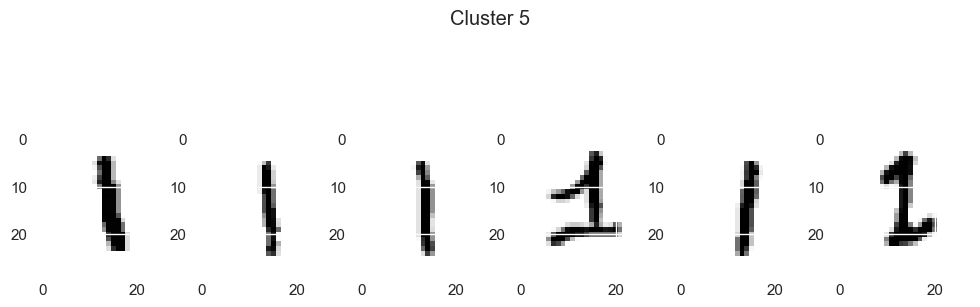

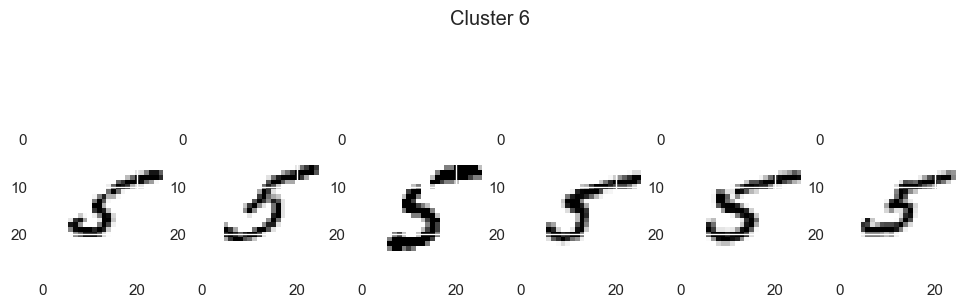

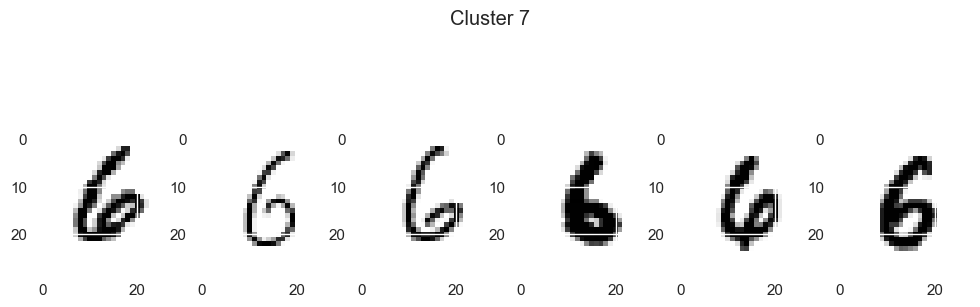

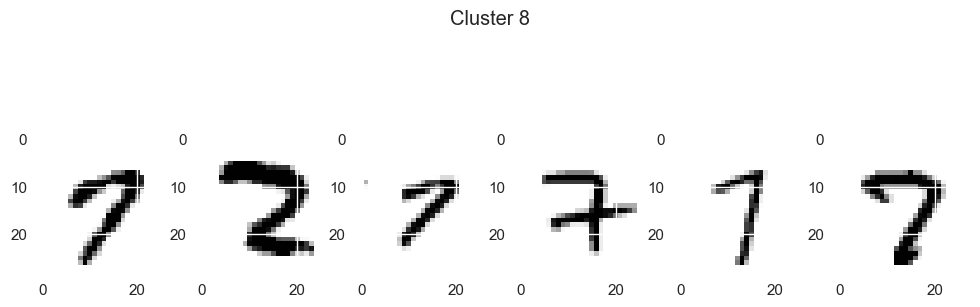

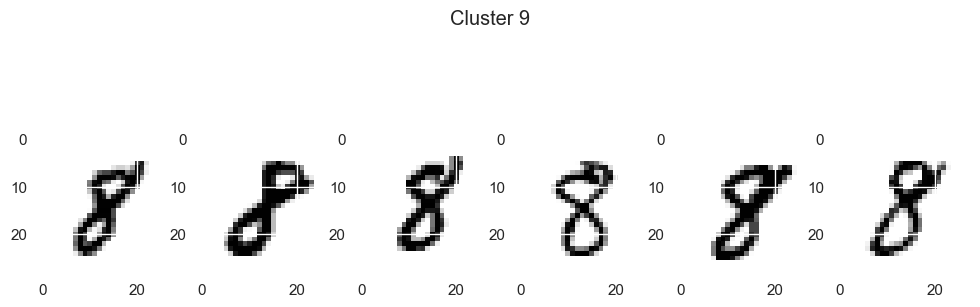

In [37]:
digits_data_rshp = np.reshape(digits_data, newshape=[digits_data.shape[0], 28, 28])

for clust_i, clust in enumerate(ig_clusters):
    
    nrows = 1
    ncols = 6
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 4*nrows))  # Adjust the size as needed

    axs = axs.flatten()

    for i, img_idx in enumerate(clust[:6]):
        axs[i].imshow(digits_data_rshp[img_idx], cmap=plt.cm.gray_r)
    fig.suptitle('Cluster {}'.format(clust_i))

### SNN graph

In [38]:
import itertools
from scipy.sparse import coo_matrix

In [39]:
# Create kdtree data structure for fast
# neighbour retreival
nearest_neigh = NearestNeighbors()
nearest_neigh = nearest_neigh.fit(digits_data)

In [40]:
neighbor_ids = nearest_neigh.kneighbors(
    digits_data, 
    n_neighbors=N_NEIGHBORS, 
    return_distance=False
)

In [41]:
neighbor_ids

array([[    0,  8728, 18774, ...,  5036,  1978,  5970],
       [    1,   639,  2581, ..., 14991,  4981,  3135],
       [    2,  4410, 10960, ...,  1630,   314,  9392],
       ...,
       [19997, 18771, 19993, ...,  3864,  9220,  5414],
       [19998, 19920, 17522, ...,  4168, 10162, 14562],
       [19999,  6011, 19993, ...,  3356,  6501, 15549]])

In [42]:
neighbor_sets = [set(row) for row in neighbor_ids]
data_point_ids = range(neighbor_ids.shape[0])
unique_pairs = list(itertools.combinations(data_point_ids, 2))

first_el = []
second_el = []
sim_value = []

jaccard_threshold = 0.1

for pair in unique_pairs:
    
    i = pair[0]
    j = pair[1]
    
    intersect_len = len(neighbor_sets[i].intersection(neighbor_sets[j]))
    union_len = 2*N_NEIGHBORS - intersect_len
    
    jaccard_similarity = intersect_len/union_len
    
    if jaccard_similarity > jaccard_threshold:
        first_el.append(i)
        second_el.append(j)
        sim_value.append(jaccard_similarity)

In [43]:
adj_matrix = coo_matrix(
    (sim_value, (first_el, second_el)), 
    shape=(neighbor_ids.shape[0], neighbor_ids.shape[0])
)

In [44]:
g = ig.Graph.Weighted_Adjacency(adj_matrix, mode="max")

Resolution 0.1
Resolution 0.2
Resolution 0.30000000000000004
Resolution 0.4
Resolution 0.5
Resolution 0.6
Resolution 0.7000000000000001
Resolution 0.8
Resolution 0.9
Resolution 1.0
Resolution 1.1


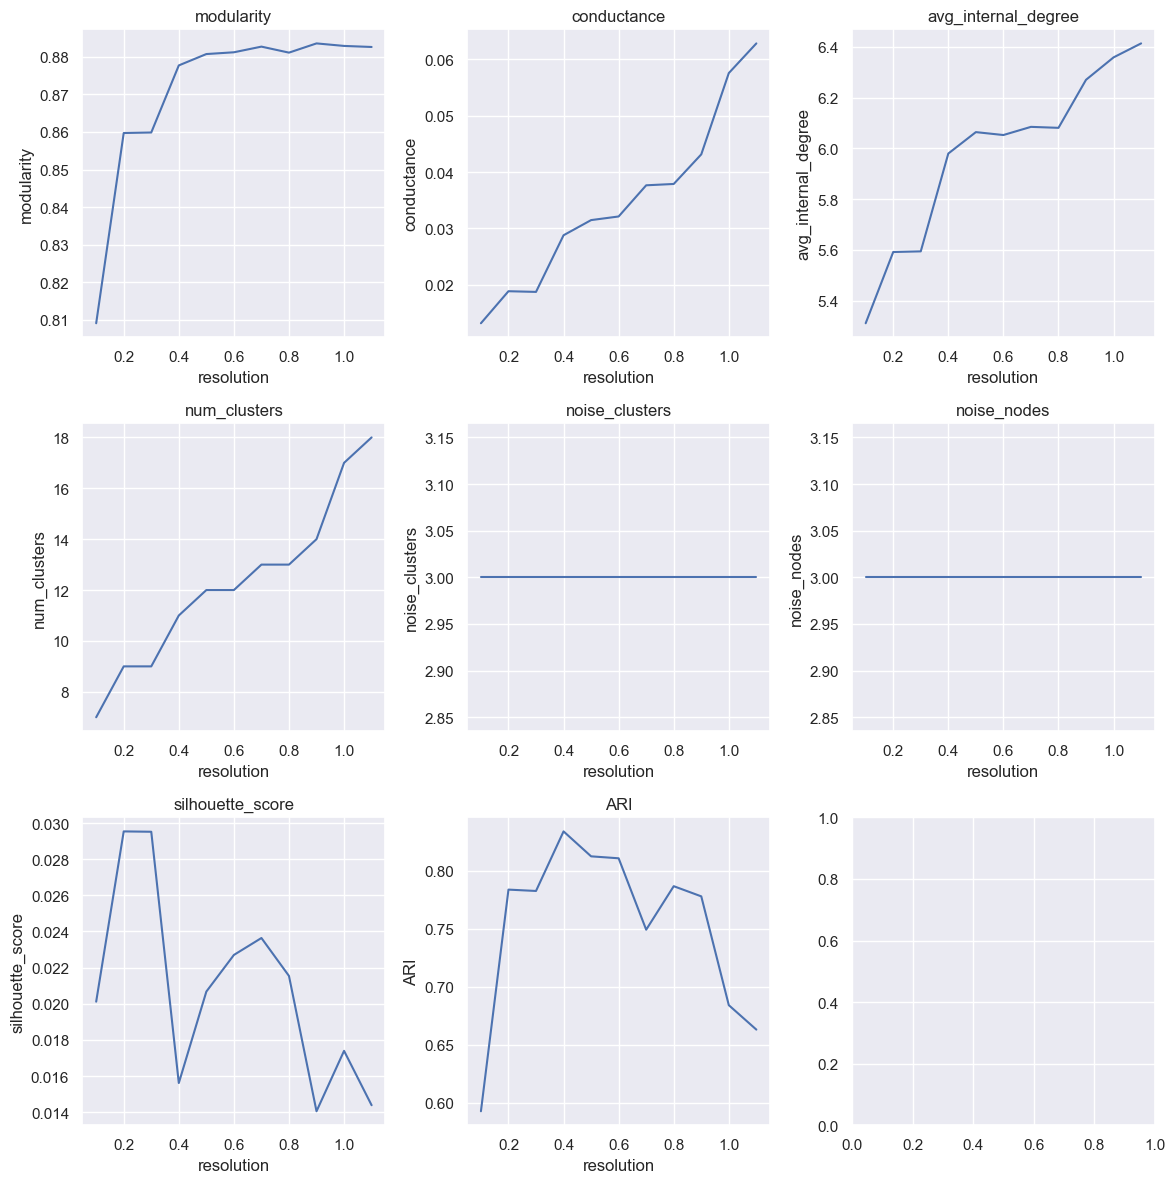

In [45]:
plot_clust_stats(
    start_res=0.1,
    end_res=1.2,
    step=0.1,
    graph=g,
    data_df=digits_data,
    original_labels=digit_labels
)

<Axes: >

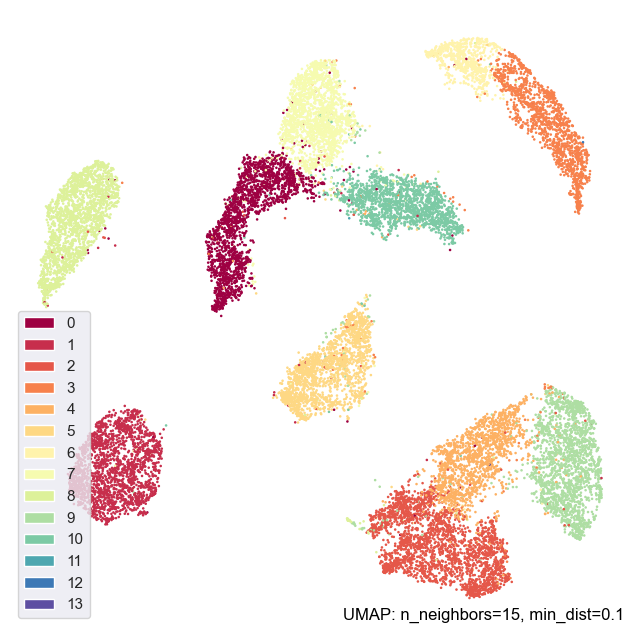

In [46]:
ig_clusters = g.community_multilevel(
    resolution=0.4,
    weights='weight'
)

uplot.points(umap_obj, labels=np.array(ig_clusters.membership))